In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch.nn.functional as F
import torch
from torch import nn, optim

In [2]:
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)

In [3]:
df = pd.read_csv('colloquial-indonesian-lexicon.csv')

In [4]:
X = df['slang']
y = df['formal']
SOS_TOKEN = 0
EOS_TOKEN = 1
PAD_TOKEN = ord('*')

In [18]:
def apply_padding(_str, n_max_char, zero_char='*'):
    len_str = len(_str)
    if len_str >= n_max_char:
        return _str[:n_max_char]
  
    else:
        return _str + ''.join([zero_char for t in range(n_max_char - len_str)])
    
def replace_punctuations(x, replace_with='*'):
    return [str(e) if str(e).isalpha() else replace_with for e in x]

def lord(x):
  """make string into integer"""
  return [SOS_TOKEN] + [ord(x1) for x1 in x] + [EOS_TOKEN]

def tchr(x):
    return ''.join([chr(y) for y in x[1:-2] if y != PAD_TOKEN])

In [19]:
def encoded_from_sentence(text):
    return lord(replace_punctuations(apply_padding(text, max_len_slang)))

def decoded_to_sentence(encoded):
    return tchr(encoded)

In [6]:
max_len_slang = X.apply(len).max()
max_len_formal = y.apply(len).max()
print('max_len_slang: {}, max_len_formal {}'.format(max_len_slang, max_len_formal))

max_len_slang: 59, max_len_formal 22


In [7]:
X = X.apply(apply_padding, args=(max_len_slang,)).apply(list).apply(np.array).apply(replace_punctuations).apply(lord)
y = y.apply(apply_padding, args=(max_len_slang,)).apply(list).apply(np.array).apply(replace_punctuations).apply(lord)

In [8]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3)

In [9]:
def to_torch(x, device=device):
    return torch.from_numpy(np.array(x.values.tolist())).to(device)

In [10]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=42)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        # make into 1x1 dimension
        embedded = self.embedding(input).view(1, 1, -1)
        
        # gru or other RNN will output: output, hidden layer
        output, hidden = self.gru(embedded, hidden)
        return output, hidden
    def init_hidden(self, device=device):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [11]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, vocab_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=42)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    def init_hidden(self, device=device):
        return torch.zeros(1,1, self.hidden_size, device=device)
        

In [65]:
input_size = max_len_slang + 1
vocab_size = 122 + 2 #include eos and sos
embed_dim = max_len_slang + 1
hidden_size = 256
output_size = max_len_slang + 1
e = Encoder(vocab_size, hidden_size)
d = Decoder(hidden_size, vocab_size)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
eoptimizer = optim.Adam(e.parameters())
doptimizer = optim.Adam(d.parameters())


In [66]:
def train(input_tensor, target_tensor, e, d, eop, dop, criterion, max_length=61):
    eh = e.init_hidden()
    eop.zero_grad()
    dop.zero_grad()
    
    input_length = input_tensor.size(0)
    output_length = output_tensor.size(0)
    
    eoutputs = torch.zeros(max_length, e.hidden_size)
    loss = 0
    
    for ei in range(input_length):

        eo, eh = e(input_tensor[ei], eh)
        eoutputs[ei] = eo[0,0]
    
    # use only last context from encoder
    dh = eh
    decoder_input = torch.tensor([[SOS_TOKEN]], device=device)
    for di in range(1, output_length):
        do, dh = d(decoder_input, dh)
        topv, topi = do.topk(1)
        decoder_input = topi.squeeze().detach()

        loss += criterion(do, target_tensor[di].view(1))
        if decoder_input.item() == EOS_TOKEN:
            break
    loss.backward()
    eop.step()
    dop.step()
    
    return loss.item() / max_length
        
    

In [ ]:
df

In [67]:
epochs = 50
losses = []
epoch_avg_losses = []

print_every = 1000
for ep in tqdm(range(epochs)):
    epoch_losses = []
    epoch_loss = 0
    for input_tensor, output_tensor in zip(to_torch(X_train.iloc[:50]), to_torch(y_train.iloc[:50])): 
        avg_loss = train(input_tensor, output_tensor, e, d, eoptimizer, doptimizer, criterion)
        losses.append(avg_loss)
        epoch_losses.append(avg_loss)
    
    epoch_loss = np.average(epoch_losses)
    epoch_avg_losses.append(epoch_loss)
        
#         for ei in range(input_size):
#             encoder_out, encoder_hidden = e()
#         encoder_out, encoder_hidden = e(to_torch(input), ehidden)
        
    

100%|██████████| 50/50 [03:06<00:00,  3.33s/it]


In [73]:
def evaluate(e, d, sentence, max_length=61, device=device):
  with torch.no_grad():
    input_tensor = to_torch(pd.Series([encoded_from_sentence(sentence)]))[0]
    input_length = input_tensor.size()[0]
    eh = e.init_hidden()
    
    eoutputs = torch.zeros(max_length, e.hidden_size, device=device)
    
    for ei in range(input_length):
      eo, eh = e(input_tensor[ei],  eh)
      eoutputs[ei] = eo[0,0]
      
    dinput = torch.tensor([[SOS_TOKEN]], device=device)
    
    doutputs = []
    dh = eh
    for di in range(max_length):
      do, dh = d(dinput, dh)
      topv, topi = do.topk(1)
      
      doutputs.append(topi.item())
      if topi.item() == EOS_TOKEN:
        break;
        
    return decoded_to_sentence(doutputs)

In [79]:
i = 11
slang = df.iloc[X_train.iloc[:50].index[i]].slang
print(slang)
print(df.iloc[X_train.iloc[:50].index[i]].formal)
pred = evaluate(e,d,slang)
print(pred)
print(len(pred))
# evaluate(e, d, 'baguuuuus')

jd
jadi
ssaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
58


In [75]:
import matplotlib.pyplot as plt

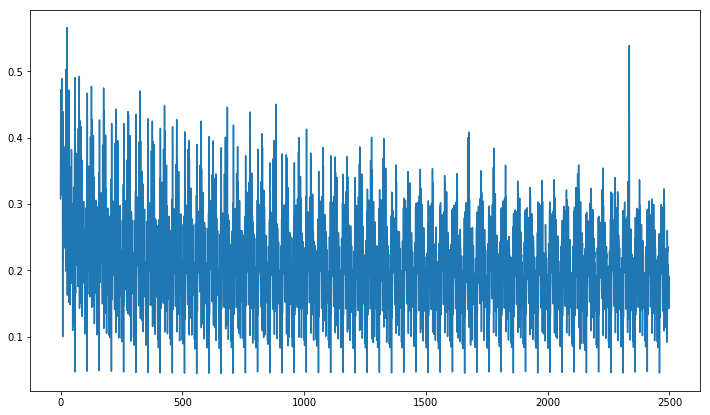

In [76]:
f, ax = plt.subplots(figsize=(12, 7))
plt.plot(list(np.arange(len(losses))), losses)
plt.show()


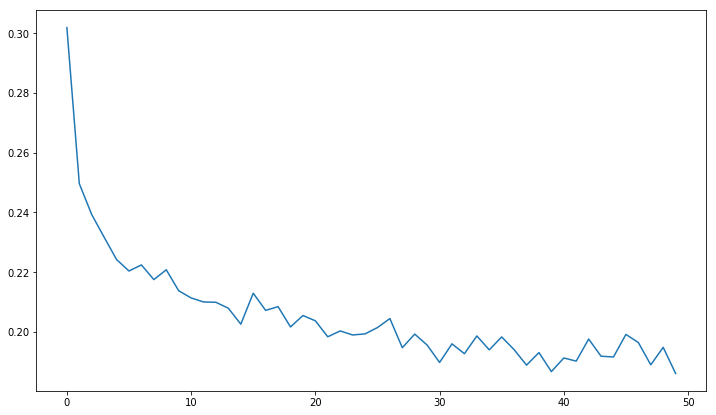

In [77]:
f, ax = plt.subplots(figsize=(12, 7))
plt.plot(list(np.arange(len(epoch_avg_losses))), epoch_avg_losses)
plt.show()